In [1]:
import numpy as np 
import pandas as pd

In [2]:
#import os
#for dirname, _, filenames in os.walk('.'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
data = pd.read_csv("glass.csv")

data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [4]:
# saving a copy of the data

data_copy = data.copy()

### Data Visualization

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

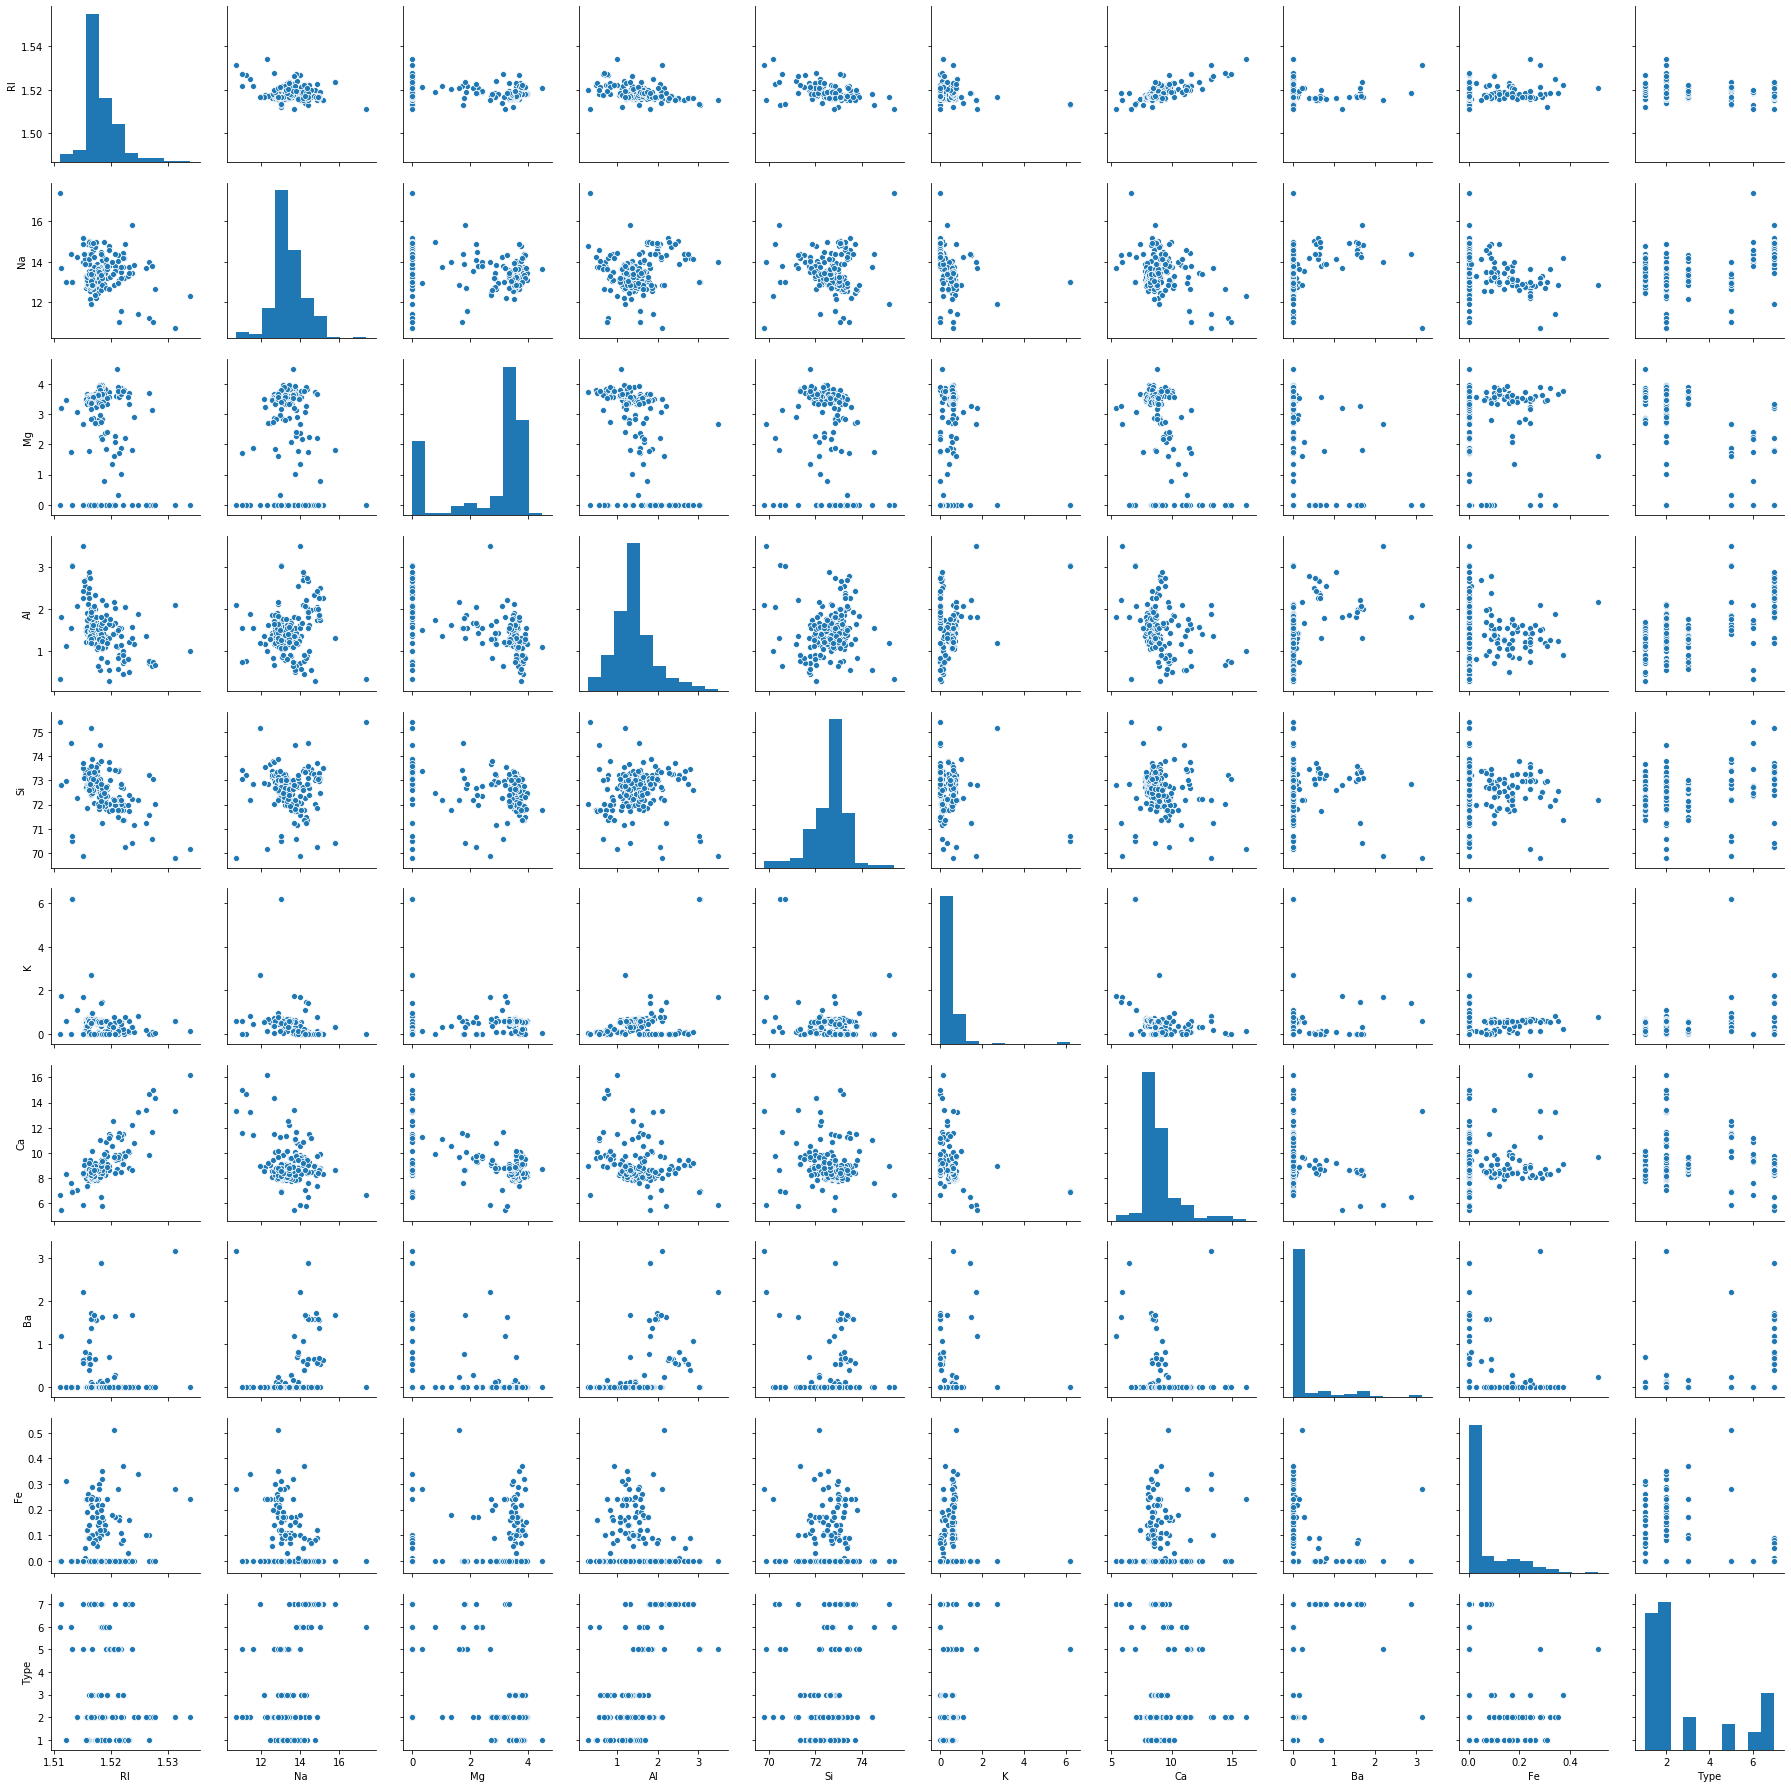

In [6]:
# pairplot of the data

sns.pairplot(data)

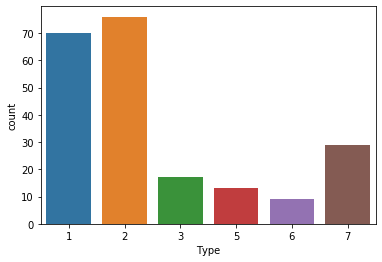

In [7]:
# target class distribution

sns.countplot(data['Type'])

we mostly have type 2 glasses and type 6 glasses are the least

In [8]:
# Plotting some columns

cols_to_plot = data.columns.drop('Type')

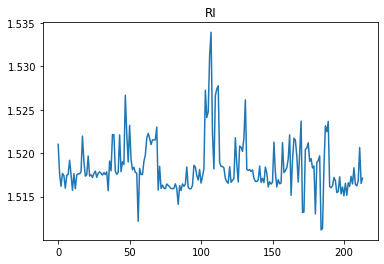

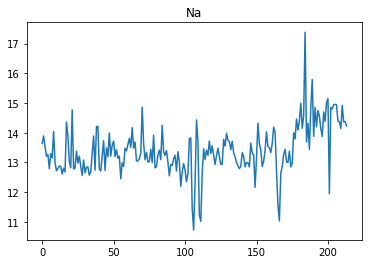

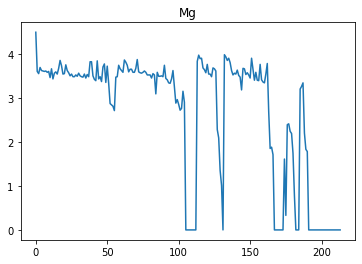

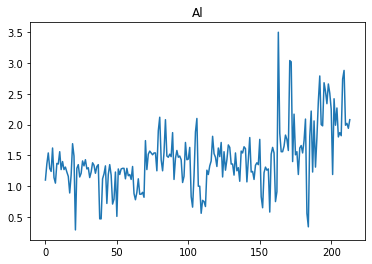

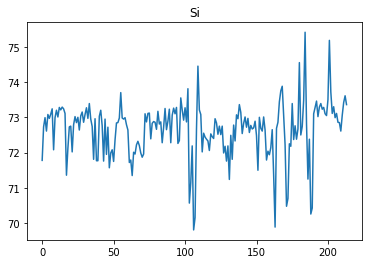

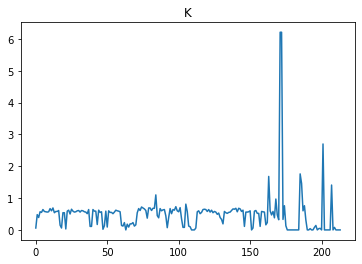

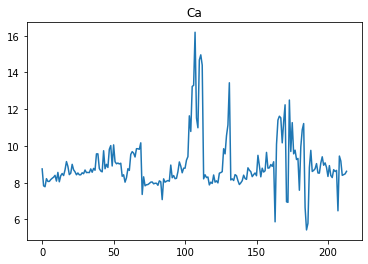

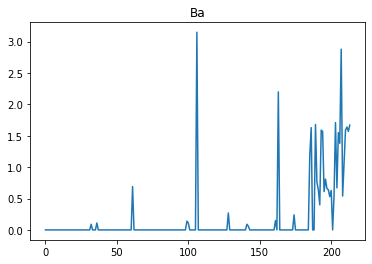

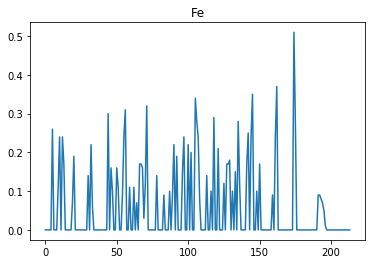

In [9]:
for col in data[cols_to_plot]:
    plt.title(col)
    plt.plot(data[col])
    plt.show()

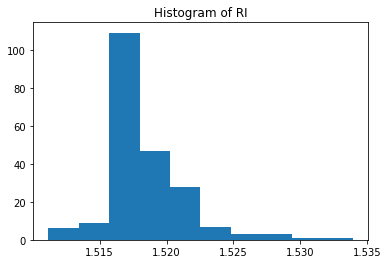

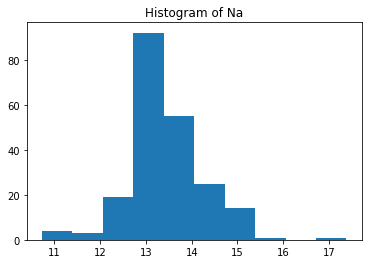

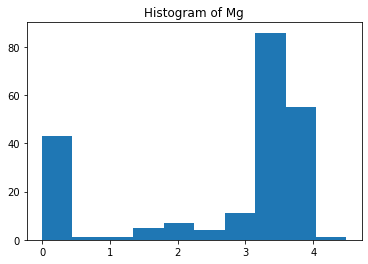

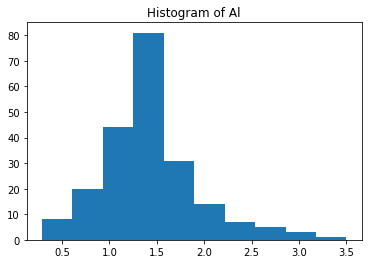

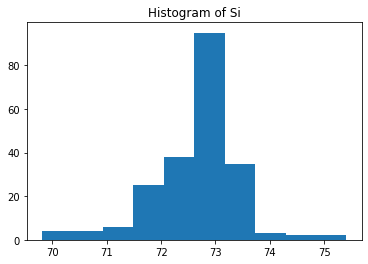

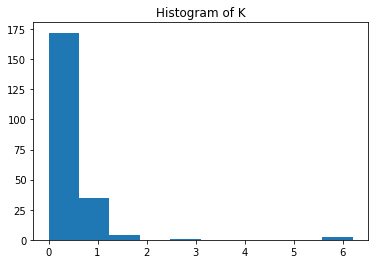

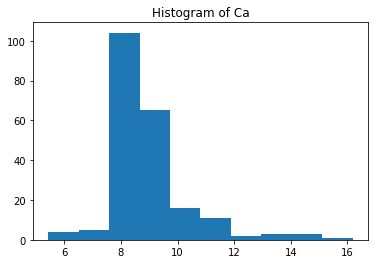

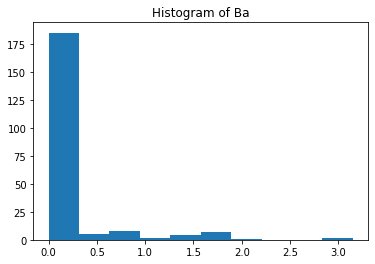

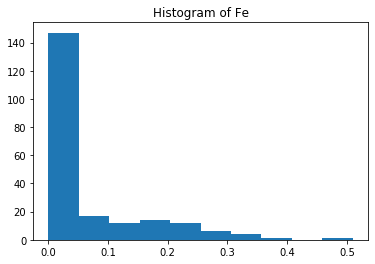

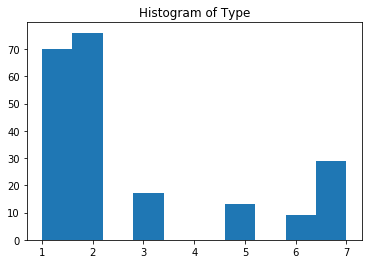

In [10]:
# Histogram of the data

for col in data.columns:
    plt.title(f'Histogram of {col}')
    plt.hist(data[col])
    plt.show()

### Correlation matrix of the data

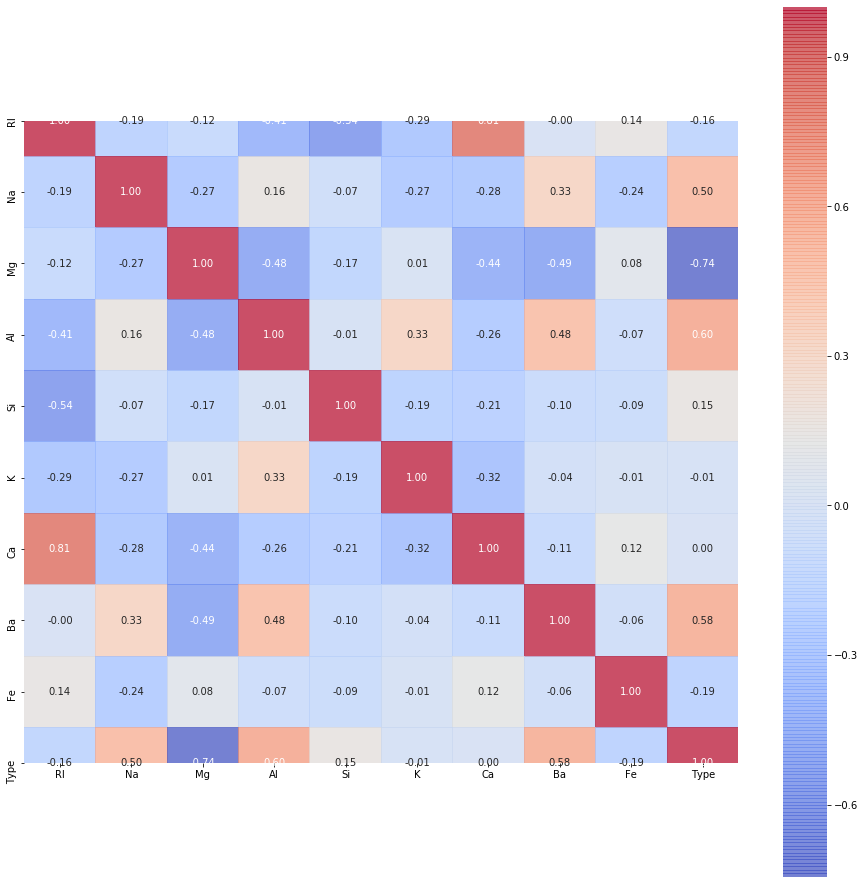

In [11]:
correlation = data.corr()

plt.figure(figsize = (16, 16))
sns.heatmap(correlation, cbar = True, square = True, annot = True, fmt = '.2f', alpha = 0.7, cmap = 'coolwarm')

plt.show()

### pre-processing

In [12]:
# checking for null values

data.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

there are no null values and we can move to the next step - checking for outliers

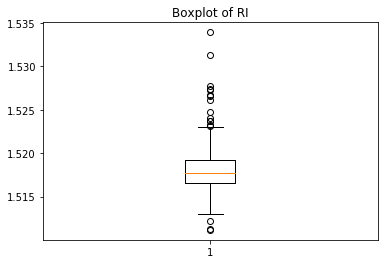

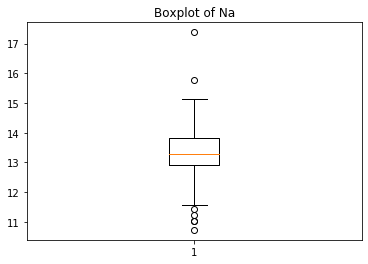

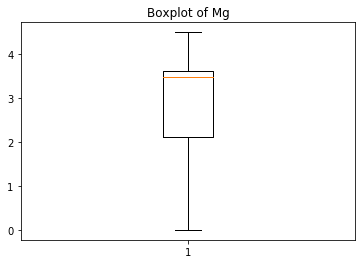

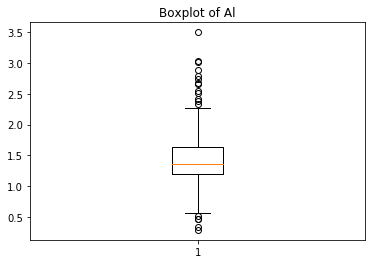

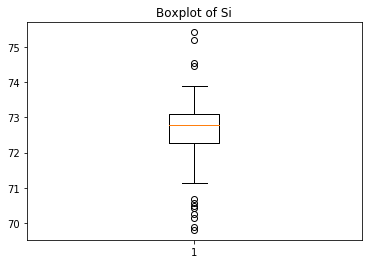

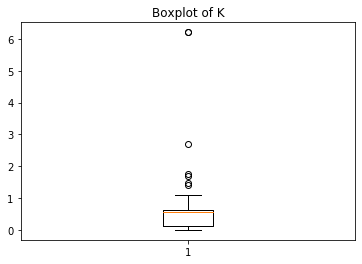

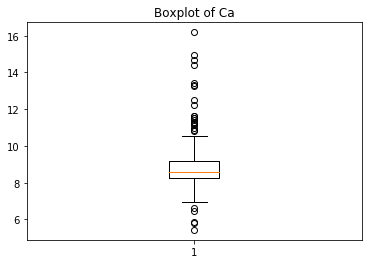

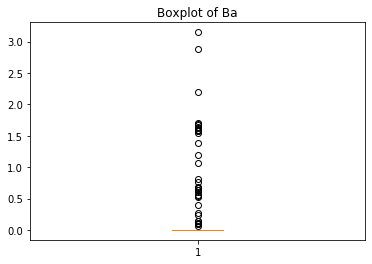

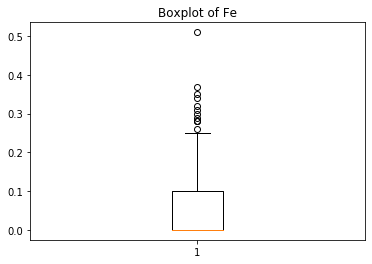

In [13]:
# outlier checking 

for col in data.columns[:-1]:
    plt.title(f'Boxplot of {col}')
    plt.boxplot(data[col])
    plt.show()

### removing the outliers

In [14]:
from collections import Counter

outliers = data.columns.drop('Type')

In [15]:
def count_outliers(data):
    indices = []
    
    # iterate over columns
    for col in data.columns.tolist():
        Q1 = np.percentile(data[col], 25) # first quartile
        Q3 = np.percentile(data[col], 75) # third quartile
        outlier = 1.5 * (Q3 - Q1)
        
        outlier_list = data[(data[col] < Q1 - outlier) | (data[col] > Q3 + outlier)].index
        
        indices.extend(outlier_list)
        
    indices = Counter(indices)
    multiple_outliers = list(k for k, v in indices.items() if v > 2)
    
    return multiple_outliers

print(len(count_outliers(data[outliers])))

14


In [16]:
indices = count_outliers(data[outliers])
data = data.drop(indices).reset_index(drop = True)

print('Shape of data with outliers: ',data_copy.shape)
print('Shape of data without outliers: ', data.shape)

Shape of data with outliers:  (214, 10)
Shape of data without outliers:  (200, 10)


we removed those 14 outliers from the data

In [17]:
# scaling the numeric values using robustscaler

from sklearn.preprocessing import RobustScaler

cols_to_scale = data.columns.drop('Type')

scaler = RobustScaler()
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

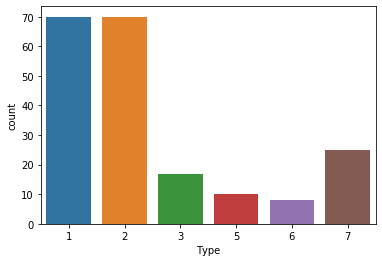

In [18]:
# lets check for class imbalance

sns.countplot(data['Type'])

we can see the imbalance in the data

In [19]:
# fixing the imbalance using oversampling


data_1 = data[data['Type']==1]
data_2 = data[data['Type']==2]

data_3 = data[data['Type']==3]
data_3 = pd.concat([data_3]*4)

data_5 = data[data['Type']==5]
data_5 = pd.concat([data_5]*5)

data_6 = data[data['Type']==6]
data_6 = pd.concat([data_6]*7)

data_7 = data[data['Type']==7]
data_7 = pd.concat([data_7]*2)

data = pd.concat([data_1, data_2, data_3, data_5, data_6, data_7])

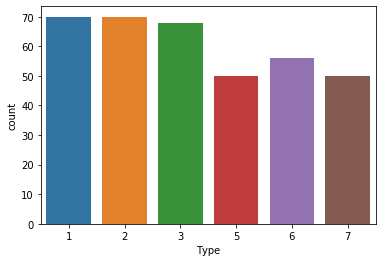

In [20]:
sns.countplot(data['Type'])

data is still not balanced but is good enough for the model to interpret

In [21]:
# Splitting the data into training and testing sets

from sklearn.model_selection import train_test_split

X, y = data.drop('Type', axis=1), data['Type']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [22]:
# Model Building and training

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
# Predictions

pred = model.predict(x_test)
pred

array([2, 1, 6, 1, 5, 2, 2, 3, 3, 3, 6, 2, 1, 7, 3, 2, 6, 7, 2, 2, 3, 1,
       7, 7, 1, 1, 3, 7, 2, 5, 3, 3, 1, 7, 2, 3, 5, 6, 7, 1, 3, 3, 2, 6,
       5, 2, 1, 1, 3, 3, 7, 3, 2, 3, 2, 2, 5, 3, 1, 7, 1, 1, 7, 1, 2, 1,
       1, 2, 6, 2, 6, 5, 3], dtype=int64)

In [25]:
# Precision, Recall and Accuracy check

from sklearn.metrics import classification_report, r2_score

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.62      0.67      0.65        15
           2       0.88      0.71      0.79        21
           3       0.82      1.00      0.90        14
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00        10

    accuracy                           0.85        73
   macro avg       0.89      0.90      0.89        73
weighted avg       0.86      0.85      0.85        73



In [26]:
print(r2_score(y_test,pred))

0.9377664109121909


our model is giving a decent accuracy.